<a href="https://colab.research.google.com/github/mamuncseru/MURA_Classification/blob/main/MURA_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d cjinny/mura-v11

100% 3.14G/3.14G [00:50<00:00, 46.1MB/s]
100% 3.14G/3.14G [00:50<00:00, 66.8MB/s]


In [4]:
import zipfile
zf = "/content/mura-v11.zip"
target_dir = "/content/drive/MyDrive/MURA"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [5]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd   

In [7]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [8]:
import tensorflow as tf
import os
import pandas as pd
import cv2
from skimage.transform import rescale, resize
from tensorflow import keras
import numpy as np
from sklearn.utils import class_weight
import tensorflow_addons as tfa
import pickle
from skimage.io import imread
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

In [9]:
#To get the filenames for a task
def filenames(part,train=True):
    root='/content/drive/MyDrive/MURA/'
    if train:
        csv_path="/content/drive/MyDrive/MURA/MURA-v1.1/train_image_paths.csv"
    else:
        csv_path="/content/drive/MyDrive/MURA/MURA-v1.1/valid_image_paths.csv"
    
    with open(csv_path, 'rb') as F:
        d = F.readlines()
        if part == 'all':
            imgs = [root + str(x, encoding='utf-8').strip() for x in d]  # 所有图片的存储路径, [:-1]目的是抛弃最末尾的\n
        else:
            imgs = [root + str(x, encoding='utf-8').strip() for x in d if
                            str(x, encoding='utf-8').strip().split('/')[2] == part]

    #imgs= [x.replace("/", "\\") for x in imgs]
    labels= [x.split('_')[-1].split('/')[0] for x in imgs]
    return imgs,labels


#To icrop a image from center
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [10]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    ToFloat(max_value=255)
])
AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])

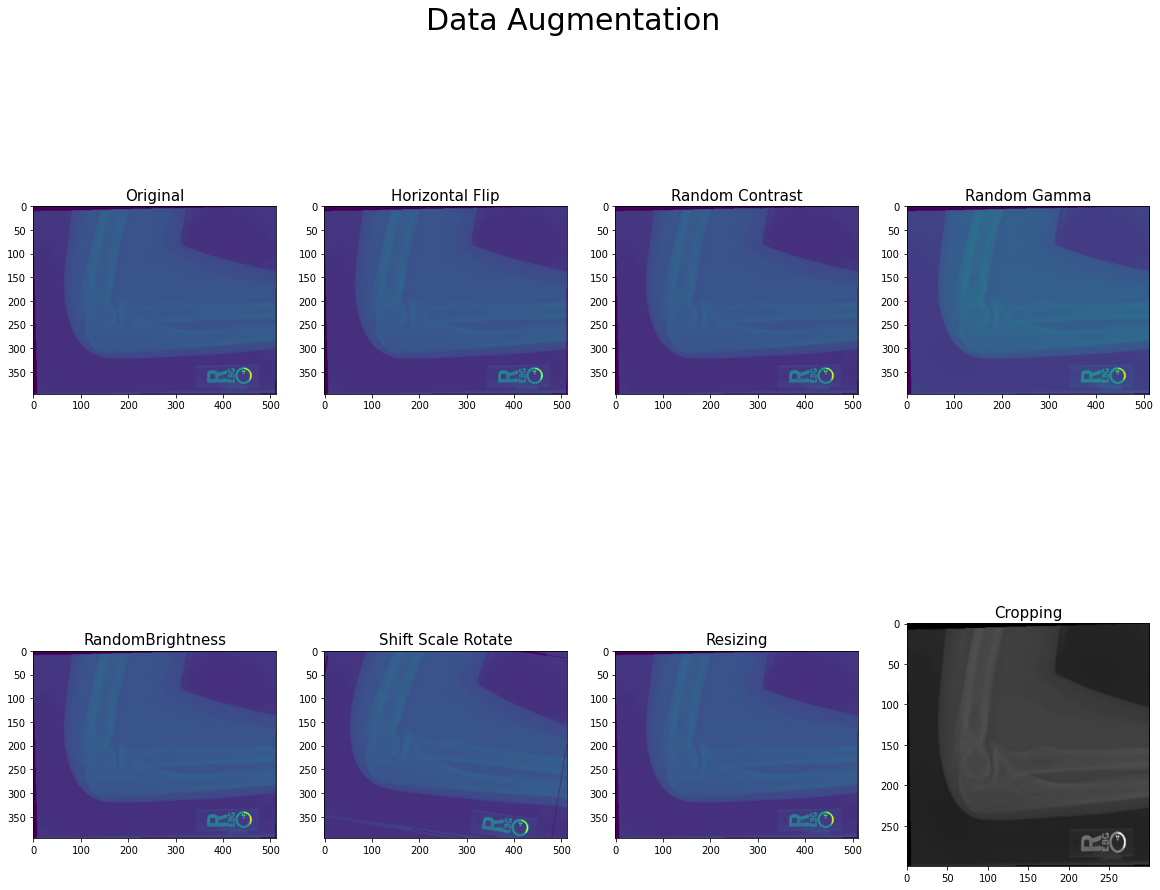

In [11]:
albumentation_list =  [
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    ToFloat(max_value=255)
]
root='/content/drive/MyDrive/MURA/'
chosen_image= imread(root+'MURA-v1.1/train/XR_ELBOW/patient01055/study1_positive/image3.png')
img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)
img= resize(chosen_image,(300,300,3))
img_matrix_list.append(img)
img_matrix_list.append(crop_center(img,224,224))

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original","Horizontal Flip","Random Contrast","Random Gamma","RandomBrightness",
               "Shift Scale Rotate","Resizing", "Cropping"]

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title="Data Augmentation"):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=2, ncols=ncols, squeeze=True)
    fig.suptitle(main_title, fontsize = 30)
    #fig.subplots_adjust(wspace=0.3)
    #fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()
    
plot_multiple_img(img_matrix_list, titles_list, ncols = 4)